# Syamesse Network with Triplet Loss

## Approach 1: ResNet50 with Triplet Loss

In [1]:
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import torch
import csv
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

random.seed(20)

#Loading the embedding features produced for this model along with Contextual Information 
#for each image in the dataset.
data = pd.read_csv('./9Data Features and Context csv/data3.csv', sep='|', low_memory=False)
data2 = pd.DataFrame(data)

#Modifying range of values of Contextual Information from the data, according to its nature, to a range between 
#0 and 1 to fit the ranges of the embedding features.
data2['C'] = (data2['C'])/3.                      #There are only three possible cameras in the data
data2['Lat'] = (data2['Lat']+90)/180.             #Values go from -90 to 90. So a possible range of 180.
data2['Long'] = (data2['Long']+180)/360.          #Values go from -180 to 180. So a possible range of 360
diff = max(data2['Time'])-min(data2['Time'])      #Obtaining maximum and minimum time in seconds registered in the data.
val = min(data2['Time'])
data2['Time'] = (data2['Time']-val)/diff          #Subtracting the value its difference with zero, and then dividing by the differnce between maximum and minumum times reported
data2['preInt'] = (data2['preInt'])/100.          #Precipitation Intensity exists between 0 and 100
data2['temp'] = (data2['temp']+7.5)/55.           #Normal temperature varies between -7.5 and 47.5
data2['press'] = (data2['press'])-min(data2['press']) 
data2['WindS'] = (data2['WindS']-2.8)/2.5         #Wind Speed varies between 2.8 and 5.3 
data2['WindG'] = (data2['WindG']-2.8)/2.5         #Wind Gust varies between 2.8 and 5.3
data2['Visb'] = (data2['Visb'])/296.              #Visibility values go from 0 to 296

#Data is randomized to partition for training and testing.
data2 = shuffle(data2, random_state=20)
data2.reset_index(drop=True, inplace=True)

total_instances = len(data2['Id'])

train_test_split = int(total_instances*0.1)

#Removing the ID and I columns from the data that will be used to train and test the model.
#Correct Ids are saved as y. The data is splitted in 90% for training and 10% for testing.
y_train = np.array(data2['Id'])
x_train = data2.loc[:, data2.columns != 'Id']
x_train = np.array(x_train.loc[:, x_train.columns != 'I'])

x_test = x_train[:train_test_split]
x_train = x_train[train_test_split:]
        
y_test = y_train[:train_test_split]
y_train = y_train[train_test_split:]

# normalizing the features before they are used to perform training.
from sklearn.preprocessing import StandardScaler
x_train = StandardScaler().fit_transform(x_train) 

print(x_train.shape)
print(x_test.shape)

(8100, 2060)
(900, 2060)


In [2]:
#Batches creation, A random image from the training set is selected as well as another image from the same id, and
#an image of different Id.
def create_batch(batch_size):
    anchors = np.zeros((batch_size, 2060))
    positives = np.zeros((batch_size, 2060))
    negatives = np.zeros((batch_size, 2060))
    
    for i in range(0, batch_size):
        #Index of a random image is seleced
        index = random.randint(0, len(x_train) - 1)
        anc = x_train[index]
        #The real ID of the random image is used to guarantee that negative and positive images will be obtained.
        y = y_train[index]
        
        indices_for_pos = np.squeeze(np.where(y_train == y)).reshape(-1,)
        indices_for_neg = np.squeeze(np.where(y_train != y)).reshape(-1,)
        
        pos = x_train[indices_for_pos[random.randint(0, len(indices_for_pos)-1)]]
        neg = x_train[indices_for_neg[random.randint(0, len(indices_for_neg)-1)]]
        
        #Anchor images, positives and negatives are saved and then returned.
        anchors[i] = anc
        positives[i] = pos
        negatives[i] = neg
        
    return [anchors, positives, negatives]

In [3]:
#Testing random triplet selection with batch size of one.
triplet = create_batch(1)
print(triplet)

[array([[ 0.67329309, -0.39846448, -0.71004623, ...,  0.41192464,
        -1.        , -1.        ]]), array([[ 0.67329309, -0.39846448, -0.71004623, ...,  0.41192464,
        -1.        , -1.        ]]), array([[-1.39719818,  0.98281081,  1.35209408, ...,  0.41192464,
        -1.        , -1.        ]])]


In [4]:
#An embedding dimension is determined for the output of our network. Data will be processed simultaneously through 
#This network in order to learn the weights that let the representation be away from the different images and close
#To the similar images, thus, learning how to make use of contextual information provided.
emb_dim = 2288

embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(2288, activation='relu', input_shape=(2060,)),
    tf.keras.layers.Dense(emb_dim, activation='sigmoid')
])

embedding_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2288)              4715568   
_________________________________________________________________
dense_1 (Dense)              (None, 2288)              5237232   
Total params: 9,952,800
Trainable params: 9,952,800
Non-trainable params: 0
_________________________________________________________________


In [5]:
#Testing the proper functioning of the model to produce the embeddings. (In this moment, with random weights).
example = x_train[0]
print(np.expand_dims(example, axis=0))

example_emb = embedding_model.predict(np.expand_dims(example, axis=0))[0]
print(example_emb)

[[ 0.67329309 -0.39846448 -0.71004623 ...  0.41192464 -1.
  -1.        ]]
[0.6899965  0.45489404 0.58851564 ... 0.2915715  0.57116514 0.6514506 ]


In [6]:
#The siamesse neural network structure is defined here. Three layers are used for input to the same embeddings
#model. This results are then fed to a concatenate layer, which produces the very same input but concatenated.

#Since this three embeddings are used to produce the output, and then to calculate the loss, this means that 
#the model is trained with the three data at the same time. Weights are shared, so if a change in the weigts 
#reduces the distance between the anchor and the positive, it should not affect the distance between the anchor 
#and the negative, otherwise, the loss function will not improve.
in_anc = tf.keras.layers.Input(shape=(2060,))
in_pos = tf.keras.layers.Input(shape=(2060,))
in_neg = tf.keras.layers.Input(shape=(2060,))

em_anc = embedding_model(in_anc)
em_pos = embedding_model(in_pos)
em_neg = embedding_model(in_neg)

out = tf.keras.layers.concatenate([em_anc, em_pos, em_neg], axis=1)

net = tf.keras.models.Model(
    [in_anc, in_pos, in_neg],
    out
)
net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2060)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2060)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 2060)]       0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 2288)         9952800     input_1[0][0]                    
                                                                 input_2[0][0]                

In [7]:
#Triplet_loss function definition, it receives a parameter alpha to determine the maximum negative distance that 
#can be produced by the embeddings, since the minimum positive distance would be idealy zero.
def triplet_loss(alpha, emb_dim):
    def loss(y_true, y_pred):
        anc, pos, neg = y_pred[:, :emb_dim], y_pred[:, emb_dim:2*emb_dim], y_pred[:, 2*emb_dim:]
        dp = tf.reduce_sum(tf.square(anc-pos), axis=1)
        dn = tf.reduce_sum(tf.square(anc-neg), axis=1)

        return tf.maximum(dp - dn + alpha, 0.)
    return loss

In [8]:
#This function is a generator, which yields batches of triplets with the batch size indicated.
def data_generator(batch_size, emb_dim):
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_dim))
        yield x, y

In [9]:
#The neural network is compiled, a batch size of 500 is defined, and a 1000 epoch training, with a number of steps
#per epoch that when multiplied by the number of batches, is similar to the number of data in the training set.
batch_size = 500
epochs = 1000
steps_per_epoch = int(len(x_train)/batch_size)

net.compile(loss=triplet_loss(alpha=1000, emb_dim=emb_dim), optimizer='adam')
        

In [10]:
#Finally the training is performed with the previously defined configurations.
history = net.fit(
    data_generator(batch_size, emb_dim),
    epochs=epochs, steps_per_epoch=steps_per_epoch,
    verbose=True
)

  ...
    to  
  ['...']
Train for 16 steps
Epoch 1/1000
16/16 [==============================] - 4s 228ms/step - loss: 330.0149
Epoch 2/1000
16/16 [==============================] - 3s 173ms/step - loss: 146.8302
Epoch 3/1000
16/16 [==============================] - 3s 176ms/step - loss: 126.7170
Epoch 4/1000
16/16 [==============================] - 3s 179ms/step - loss: 112.8515
Epoch 5/1000
16/16 [==============================] - 3s 179ms/step - loss: 108.3832
Epoch 6/1000
16/16 [==============================] - 3s 171ms/step - loss: 104.2226
Epoch 7/1000
16/16 [==============================] - 3s 194ms/step - loss: 96.3749
Epoch 8/1000
16/16 [==============================] - 3s 171ms/step - loss: 87.2589
Epoch 9/1000
16/16 [==============================] - 3s 167ms/step - loss: 87.5182
Epoch 10/1000
16/16 [==============================] - 3s 167ms/step - loss: 81.1574
Epoch 11/1000
16/16 [==============================] - 3s 167ms/step - loss: 75.1722
Epoch 12/1000
16/16 [===

16/16 [==============================] - 3s 170ms/step - loss: 22.8217
Epoch 97/1000
16/16 [==============================] - 3s 170ms/step - loss: 23.4529
Epoch 98/1000
16/16 [==============================] - 3s 170ms/step - loss: 25.4950
Epoch 99/1000
16/16 [==============================] - 3s 169ms/step - loss: 23.1822
Epoch 100/1000
16/16 [==============================] - 3s 170ms/step - loss: 23.9118
Epoch 101/1000
16/16 [==============================] - 3s 170ms/step - loss: 23.3288
Epoch 102/1000
16/16 [==============================] - 3s 170ms/step - loss: 20.4421
Epoch 103/1000
16/16 [==============================] - 3s 170ms/step - loss: 24.1864
Epoch 104/1000
16/16 [==============================] - 3s 171ms/step - loss: 21.6339
Epoch 105/1000
16/16 [==============================] - 3s 170ms/step - loss: 22.0502
Epoch 106/1000
16/16 [==============================] - 3s 170ms/step - loss: 20.8877
Epoch 107/1000
16/16 [==============================] - 3s 170ms/step - 

16/16 [==============================] - 3s 170ms/step - loss: 14.3912
Epoch 192/1000
16/16 [==============================] - 3s 169ms/step - loss: 13.3825
Epoch 193/1000
16/16 [==============================] - 3s 170ms/step - loss: 14.6985
Epoch 194/1000
16/16 [==============================] - 3s 170ms/step - loss: 14.9027
Epoch 195/1000
16/16 [==============================] - 3s 170ms/step - loss: 13.4862
Epoch 196/1000
16/16 [==============================] - 3s 170ms/step - loss: 13.9996
Epoch 197/1000
16/16 [==============================] - 3s 170ms/step - loss: 12.5285
Epoch 198/1000
16/16 [==============================] - 3s 170ms/step - loss: 14.1123
Epoch 199/1000
16/16 [==============================] - 3s 170ms/step - loss: 13.0089
Epoch 200/1000
16/16 [==============================] - 3s 170ms/step - loss: 13.1702
Epoch 201/1000
16/16 [==============================] - 3s 170ms/step - loss: 14.8851
Epoch 202/1000
16/16 [==============================] - 3s 169ms/step

16/16 [==============================] - 3s 169ms/step - loss: 7.9218
Epoch 287/1000
16/16 [==============================] - 3s 169ms/step - loss: 9.0281
Epoch 288/1000
16/16 [==============================] - 3s 169ms/step - loss: 7.8311
Epoch 289/1000
16/16 [==============================] - 3s 169ms/step - loss: 7.3736
Epoch 290/1000
16/16 [==============================] - 3s 169ms/step - loss: 7.4350
Epoch 291/1000
16/16 [==============================] - 3s 169ms/step - loss: 9.5096
Epoch 292/1000
16/16 [==============================] - 3s 169ms/step - loss: 8.1344
Epoch 293/1000
16/16 [==============================] - 3s 170ms/step - loss: 8.8592
Epoch 294/1000
16/16 [==============================] - 3s 170ms/step - loss: 9.3126
Epoch 295/1000
16/16 [==============================] - 3s 169ms/step - loss: 9.1910
Epoch 296/1000
16/16 [==============================] - 3s 169ms/step - loss: 7.8209
Epoch 297/1000
16/16 [==============================] - 3s 169ms/step - loss: 8.

16/16 [==============================] - 3s 169ms/step - loss: 5.3200
Epoch 383/1000
16/16 [==============================] - 3s 168ms/step - loss: 6.8118
Epoch 384/1000
16/16 [==============================] - 3s 169ms/step - loss: 7.3451
Epoch 385/1000
16/16 [==============================] - 3s 169ms/step - loss: 6.1865
Epoch 386/1000
16/16 [==============================] - 3s 168ms/step - loss: 5.6774
Epoch 387/1000
16/16 [==============================] - 3s 168ms/step - loss: 5.5811
Epoch 388/1000
16/16 [==============================] - 3s 173ms/step - loss: 7.3927
Epoch 389/1000
16/16 [==============================] - 3s 180ms/step - loss: 7.3795
Epoch 390/1000
16/16 [==============================] - 3s 176ms/step - loss: 5.7217
Epoch 391/1000
16/16 [==============================] - 3s 177ms/step - loss: 5.0078
Epoch 392/1000
16/16 [==============================] - 3s 182ms/step - loss: 5.8355
Epoch 393/1000
16/16 [==============================] - 3s 174ms/step - loss: 5.

16/16 [==============================] - 3s 178ms/step - loss: 4.2979
Epoch 479/1000
16/16 [==============================] - 3s 184ms/step - loss: 3.6881
Epoch 480/1000
16/16 [==============================] - 3s 180ms/step - loss: 4.8166
Epoch 481/1000
16/16 [==============================] - 3s 179ms/step - loss: 4.4988
Epoch 482/1000
16/16 [==============================] - 3s 189ms/step - loss: 4.9300
Epoch 483/1000
16/16 [==============================] - 3s 179ms/step - loss: 3.9370
Epoch 484/1000
16/16 [==============================] - 3s 181ms/step - loss: 4.7630
Epoch 485/1000
16/16 [==============================] - 3s 175ms/step - loss: 3.8696
Epoch 486/1000
16/16 [==============================] - 3s 176ms/step - loss: 4.4597
Epoch 487/1000
16/16 [==============================] - 3s 184ms/step - loss: 3.4444
Epoch 488/1000
16/16 [==============================] - 3s 176ms/step - loss: 3.5320
Epoch 489/1000
16/16 [==============================] - 3s 186ms/step - loss: 4.

16/16 [==============================] - 3s 176ms/step - loss: 3.7659
Epoch 575/1000
16/16 [==============================] - 3s 183ms/step - loss: 3.1693
Epoch 576/1000
16/16 [==============================] - 3s 179ms/step - loss: 3.2802
Epoch 577/1000
16/16 [==============================] - 3s 183ms/step - loss: 4.1018
Epoch 578/1000
16/16 [==============================] - 3s 184ms/step - loss: 4.3809
Epoch 579/1000
16/16 [==============================] - 3s 176ms/step - loss: 3.7013
Epoch 580/1000
16/16 [==============================] - 3s 167ms/step - loss: 4.2755
Epoch 581/1000
16/16 [==============================] - 3s 169ms/step - loss: 3.5246
Epoch 582/1000
16/16 [==============================] - 3s 176ms/step - loss: 3.9853
Epoch 583/1000
16/16 [==============================] - 3s 175ms/step - loss: 3.6996
Epoch 584/1000
16/16 [==============================] - 3s 167ms/step - loss: 3.7551
Epoch 585/1000
16/16 [==============================] - 3s 167ms/step - loss: 4.

16/16 [==============================] - 3s 165ms/step - loss: 2.9096
Epoch 671/1000
16/16 [==============================] - 3s 165ms/step - loss: 2.5118
Epoch 672/1000
16/16 [==============================] - 3s 166ms/step - loss: 2.6753
Epoch 673/1000
16/16 [==============================] - 3s 165ms/step - loss: 3.0754
Epoch 674/1000
16/16 [==============================] - 3s 165ms/step - loss: 3.1867
Epoch 675/1000
16/16 [==============================] - 3s 166ms/step - loss: 2.4928
Epoch 676/1000
16/16 [==============================] - 3s 171ms/step - loss: 3.3402
Epoch 677/1000
16/16 [==============================] - 3s 173ms/step - loss: 2.7306
Epoch 678/1000
16/16 [==============================] - 3s 168ms/step - loss: 3.4398
Epoch 679/1000
16/16 [==============================] - 3s 165ms/step - loss: 2.9717
Epoch 680/1000
16/16 [==============================] - 3s 165ms/step - loss: 2.6964
Epoch 681/1000
16/16 [==============================] - 3s 166ms/step - loss: 3.

16/16 [==============================] - 3s 167ms/step - loss: 1.7379
Epoch 767/1000
16/16 [==============================] - 3s 167ms/step - loss: 2.3589
Epoch 768/1000
16/16 [==============================] - 3s 167ms/step - loss: 2.0951
Epoch 769/1000
16/16 [==============================] - 3s 167ms/step - loss: 2.4069
Epoch 770/1000
16/16 [==============================] - 3s 166ms/step - loss: 2.4707
Epoch 771/1000
16/16 [==============================] - 3s 167ms/step - loss: 2.7016
Epoch 772/1000
16/16 [==============================] - 3s 167ms/step - loss: 2.9693
Epoch 773/1000
16/16 [==============================] - 3s 168ms/step - loss: 1.9763
Epoch 774/1000
16/16 [==============================] - 3s 167ms/step - loss: 2.5268
Epoch 775/1000
16/16 [==============================] - 3s 167ms/step - loss: 2.5577
Epoch 776/1000
16/16 [==============================] - 3s 167ms/step - loss: 1.7958
Epoch 777/1000
16/16 [==============================] - 3s 167ms/step - loss: 1.

16/16 [==============================] - 3s 164ms/step - loss: 2.7147
Epoch 863/1000
16/16 [==============================] - 3s 164ms/step - loss: 2.2321
Epoch 864/1000
16/16 [==============================] - 3s 165ms/step - loss: 1.6474
Epoch 865/1000
16/16 [==============================] - 3s 165ms/step - loss: 1.1242
Epoch 866/1000
16/16 [==============================] - 3s 165ms/step - loss: 1.7790
Epoch 867/1000
16/16 [==============================] - 3s 164ms/step - loss: 2.4489
Epoch 868/1000
16/16 [==============================] - 3s 172ms/step - loss: 1.8543
Epoch 869/1000
16/16 [==============================] - 3s 179ms/step - loss: 3.3263
Epoch 870/1000
16/16 [==============================] - 3s 178ms/step - loss: 1.6105
Epoch 871/1000
16/16 [==============================] - 3s 173ms/step - loss: 2.8329
Epoch 872/1000
16/16 [==============================] - 3s 168ms/step - loss: 1.5785
Epoch 873/1000
16/16 [==============================] - 3s 168ms/step - loss: 2.

16/16 [==============================] - 3s 168ms/step - loss: 2.5811
Epoch 959/1000
16/16 [==============================] - 3s 167ms/step - loss: 1.9151
Epoch 960/1000
16/16 [==============================] - 3s 167ms/step - loss: 2.0533
Epoch 961/1000
16/16 [==============================] - 3s 167ms/step - loss: 2.1352
Epoch 962/1000
16/16 [==============================] - 3s 167ms/step - loss: 2.0234
Epoch 963/1000
16/16 [==============================] - 3s 168ms/step - loss: 1.7330
Epoch 964/1000
16/16 [==============================] - 3s 174ms/step - loss: 1.4843
Epoch 965/1000
16/16 [==============================] - 3s 177ms/step - loss: 1.9157
Epoch 966/1000
16/16 [==============================] - 3s 171ms/step - loss: 2.7684
Epoch 967/1000
16/16 [==============================] - 3s 167ms/step - loss: 1.6324
Epoch 968/1000
16/16 [==============================] - 3s 167ms/step - loss: 2.2365
Epoch 969/1000
16/16 [==============================] - 3s 170ms/step - loss: 2.

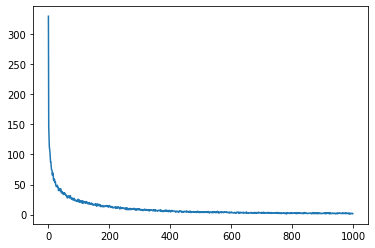

In [11]:
#We can plot the loss during the training process to visualize how the model adapts to the data.
plt.plot(history.history["loss"])
plt.show()

In [12]:
#As we might remember, the only trainable part of the model, was the one used to produce the embeddings.
#This part of the model is extracted and will be put into test usint the testing set.
model = net.get_layer(name="sequential")

In [13]:
#Since the data used for training was nornalized first, then we do the same with the testing set.
from sklearn.preprocessing import StandardScaler
x_test = StandardScaler().fit_transform(x_test) # normalizing the features

print(x_test.shape)

#We produce the new embeddings including the contextual information processed, to check its metrics.
result = model.predict(x_test)

print(result.shape)

(900, 2060)
(900, 2288)


In [14]:
#We use eucliudean distance, since is the kind of distance that was used during the training. And calculate every
#Distance between the images in the test set.

from sklearn.metrics.pairwise import euclidean_distances

result = np.array(result)
print(result)

distances = euclidean_distances(result, result)
print(distances.shape)

[[1.0000000e+00 1.0000000e+00 1.3781493e-19 ... 1.0000000e+00
  4.5984368e-08 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 2.4193420e-22 ... 3.3792347e-34
  1.0000000e+00 0.0000000e+00]
 [2.5512056e-10 1.6410978e-22 8.2834131e-01 ... 6.9330313e-25
  6.7483542e-36 9.9997723e-01]
 ...
 [3.5240757e-20 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 1.0000000e+00]
 [4.5591727e-34 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 1.0000000e+00]
 [2.5911920e-04 4.2969828e-10 9.9998903e-01 ... 1.5619865e-03
  1.0000000e+00 0.0000000e+00]]
(900, 900)


In [15]:
#For the test set, a subset of images needs to be selected as query, and the rest is used for the gallery, so no 
#image in the query should exist in the gallery, otherwise the distance would be zero. To ensure that this does 
#not happen, we first change the value to infinity to the distance of every image with itself.
querys = []
verification =  []
    
i = 0
for row in distances:
    row[i]=np.inf
    distances[i] = row
    i = i+1
    
random.seed(20)

#Then we take 20 percent of the test set for querys and the rest for gallery, as it is shown below.
numlst = list(range(len(distances))) 
random.shuffle(numlst)

split = int(len(distances)*0.2)

queryIndexes = numlst[:split]
     
#In order to calculate the metrics, we take a relevant subset of the ordered data, because at a certain point, the
#rest of the data is not relevant for mean Average Prceision calculation.
mostRelevantIndices = int(len(distances)*0.75)
    
for queryIndex in queryIndexes:
    top_20_idx = np.argsort(distances[queryIndex])[:mostRelevantIndices]
    top_20_values = [distances[queryIndex][i] for i in top_20_idx]
    querys.append(top_20_idx)
    verification.append(top_20_values)

In [16]:
eucDist = [] 
areSame = []
qI = []
rI = []
Id = y_test

#We calculate for each query image against the gallery, its most closest (and therefore more similar) images. Then
#we verify if they are the same, and save the query and gallery indexes, as well as the distances between them.
i = 0
for query in querys:
    for j in range(mostRelevantIndices):
        eucDist.append(verification[i][j])
        areSame.append(int(y_test[query[j]]==y_test[queryIndexes[i]]))
        qI.append(y_test[queryIndexes[i]])
        rI.append(y_test[query[j]])
    i=i+1
    
data3Final = []
data3Final = pd.DataFrame(data3Final)

data3Final['eucDist'] = eucDist
data3Final['areSame'] = areSame
data3Final['qI'] = qI
data3Final['rI'] = rI

print(data3Final)

          eucDist  areSame   qI   rI
0        4.374765        1  412  412
1        4.481573        1  412  412
2        4.482000        1  412  412
3        4.524382        1  412  412
4        4.532840        1  412  412
...           ...      ...  ...  ...
121495  35.342323        0   15   47
121496  35.345642        0   15   47
121497  35.348335        0   15   47
121498  35.349854        0   15   48
121499  35.350273        0   15  145

[121500 rows x 4 columns]


In [17]:
from argparse import ArgumentParser, FileType
from importlib import import_module
from itertools import count
import os

import json
import numpy as np
from sklearn.metrics import average_precision_score

average_precision = average_precision_score

# Loop over the query embeddings and compute their APs and the CMC curve.
aps = []
cmc = np.zeros(split, dtype=np.int32)

distances = np.array(data3Final['eucDist'])
pid_matches = np.array(data3Final['areSame'])

print(pid_matches)

[1 1 1 ... 0 0 0]


In [18]:
scores = 1 / (1 + distances)

for i in range(split):
    ap = average_precision(pid_matches[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices], scores[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices])

    if np.isnan(ap):
        print()
        print("WARNING: encountered an AP of NaN!")
        print("This usually means a person only appears once.")
        print("In this case, it's because of {}.".format(i))
        print("I'm excluding this person from eval and carrying on.")
        print()
        continue

    aps.append(ap)
    # Find the first true match and increment the cmc data from there on.
    try:
        k = np.where(pid_matches[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices] == 1)[0][0]
    except:
        k = -1
    cmc[k:] += 1

# Compute the actual cmc and mAP values
cmc = cmc / split
mean_ap = np.mean(aps)

# Save important data
#if args.filename is not None:
#    json.dump({'mAP': mean_ap, 'CMC': list(cmc), 'aps': list(aps)}, args.filename)

# Print out a short summary.
print('mAP: {:.2%} | top-1: {:.2%} top-2: {:.2%} | top-5: {:.2%} | top-10: {:.2%}'.format(mean_ap, cmc[0], cmc[1], cmc[4], cmc[9]))


This usually means a person only appears once.
In this case, it's because of 2.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 7.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 9.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 22.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 23.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 25.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 29.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In 

/home/dell_mserver_01/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


### Original evaluation

In [329]:
import torch
import csv
import numpy as np
import pandas as pd
from sklearn.utils import resample
import random
from sklearn.utils import shuffle

random.seed(20)

data = pd.read_csv('data3.csv', sep='|', low_memory=False)
data2 = pd.DataFrame(data)

#Data is randomized to partition for training and testing.
data2 = shuffle(data2, random_state = 20)
data2.reset_index(drop=True, inplace=True)

total_instances = len(data2['Id'])

train_test_split = int(total_instances*0.1)

#Removing the contextual data and only preserving the original embedding, as produced by the algorithm.
aditionalData = ["C", "Lat", "Long", "Time", "preInt", "temp", "hum", "press", "WindS", "WindG", "CloudC", "Visb"]

data2_feats = data2.drop(aditionalData, axis = 1)

y = np.array(data2['Id'])
x = data2_feats.loc[:, data2_feats.columns != 'Id']
x = np.array(x.loc[:, x.columns != 'I'])

x_test = x[:train_test_split]
y_test = y[:train_test_split]

print(x_test.shape)

(800, 2048)


In [330]:
from sklearn.metrics.pairwise import euclidean_distances

result = np.array(x_test)
print(result)

distances = euclidean_distances(result, result)
print(distances.shape)

[[0.01118349 0.02371171 0.02286469 ... 0.0078323  0.01103955 0.0065171 ]
 [0.0117231  0.0211491  0.02077247 ... 0.0046381  0.00712652 0.01197363]
 [0.00733403 0.01340942 0.01532066 ... 0.0075647  0.01012447 0.00537336]
 ...
 [0.01408709 0.02742689 0.01655402 ... 0.00575824 0.01353167 0.00970103]
 [0.00223651 0.01966643 0.01051405 ... 0.00792209 0.01073992 0.0096026 ]
 [0.00433547 0.02366976 0.01159901 ... 0.00472704 0.00909662 0.00631366]]
(800, 800)


In [331]:
querys = []
verification =  []

i = 0
for row in distances:
    row[i]=np.inf
    distances[i] = row
    i = i+1

random.seed(20)

numlst = list(range(len(distances))) 
random.shuffle(numlst)

split = int(len(distances)*0.2)

queryIndexes = numlst[:split]
     
mostRelevantIndices = int(len(distances)*0.75)
    
for queryIndex in queryIndexes:
    top_20_idx = np.argsort(distances[queryIndex])[:mostRelevantIndices]
    top_20_values = [distances[queryIndex][i] for i in top_20_idx]
    querys.append(top_20_idx)
    verification.append(top_20_values)

In [332]:
eucDist = [] 
areSame = []
qI = []
rI = []
Id = y_test
    
i = 0
for query in querys:
    for j in range(mostRelevantIndices):
        eucDist.append(verification[i][j])
        areSame.append(int(y_test[query[j]]==y_test[queryIndexes[i]]))
        qI.append(y_test[queryIndexes[i]])
        rI.append(y_test[query[j]])
    i=i+1
    
data3Final = []
data3Final = pd.DataFrame(data3Final)

data3Final['eucDist'] = eucDist
data3Final['areSame'] = areSame
data3Final['qI'] = qI
data3Final['rI'] = rI

print(data3Final)

        eucDist  areSame   qI   rI
0      0.114032        1  213  213
1      0.151979        1  213  213
2      0.164643        0  213  291
3      0.170837        0  213  291
4      0.171733        1  213  213
...         ...      ...  ...  ...
95995  0.416801        0  236  195
95996  0.416932        0  236  347
95997  0.417106        0  236   15
95998  0.417267        0  236   78
95999  0.417279        0  236  190

[96000 rows x 4 columns]


In [333]:
from argparse import ArgumentParser, FileType
from importlib import import_module
from itertools import count
import os

import json
import numpy as np
from sklearn.metrics import average_precision_score

average_precision = average_precision_score

# Loop over the query embeddings and compute their APs and the CMC curve.
aps = []
cmc = np.zeros(split, dtype=np.int32)

distances = np.array(data3Final['eucDist'])
pid_matches = np.array(data3Final['areSame'])

print(pid_matches)

[1 1 0 ... 0 0 0]


In [334]:
scores = 1 / (1 + distances)

for i in range(split):
    ap = average_precision(pid_matches[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices], scores[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices])

    if np.isnan(ap):
        print()
        print("WARNING: encountered an AP of NaN!")
        print("This usually means a person only appears once.")
        print("In this case, it's because of {}.".format(i))
        print("I'm excluding this person from eval and carrying on.")
        print()
        continue

    aps.append(ap)
    # Find the first true match and increment the cmc data from there on.
    try:
        k = np.where(pid_matches[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices] == 1)[0][0]
    except:
        k = -1
    cmc[k:] += 1

# Compute the actual cmc and mAP values
cmc = cmc / split
mean_ap = np.mean(aps)

# Save important data
#if args.filename is not None:
#    json.dump({'mAP': mean_ap, 'CMC': list(cmc), 'aps': list(aps)}, args.filename)

# Print out a short summary.
print('mAP: {:.2%} | top-1: {:.2%} top-2: {:.2%} | top-5: {:.2%} | top-10: {:.2%}'.format(mean_ap, cmc[0], cmc[1], cmc[4], cmc[9]))


This usually means a person only appears once.
In this case, it's because of 8.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 16.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 20.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 27.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 35.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 38.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 52.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
I

/home/dell_mserver_01/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


## Approach 2: MGN

In [5]:
import torch
import csv
import numpy as np
import pandas as pd
from sklearn.utils import resample
import tensorflow as tf
import random
from sklearn.utils import shuffle

#Loading the embedding features produced for this model along with Contextual Information 
#for each image in the dataset.
data = pd.read_csv('./9Data Features and Context csv/data3MGN.csv', sep='|', low_memory=False)
data2 = pd.DataFrame(data)

#Modifying range of values of Contextual Information from the data, according to its nature, to a range between 
#0 and 1 to fit the ranges of the embedding features.
data2['C'] = (data2['C'])/3.                      #There are only three possible cameras in the data
data2['Lat'] = (data2['Lat']+90)/180.             #Values go from -90 to 90. So a possible range of 180.
data2['Long'] = (data2['Long']+180)/360.          #Values go from -180 to 180. So a possible range of 360
diff = max(data2['Time'])-min(data2['Time'])      #Obtaining maximum and minimum time in seconds registered in the data.
val = min(data2['Time'])
data2['Time'] = (data2['Time']-val)/diff          #Subtracting the value its difference with zero, and then dividing by the differnce between maximum and minumum times reported
data2['preInt'] = (data2['preInt'])/100.          #Precipitation Intensity exists between 0 and 100
data2['temp'] = (data2['temp']+7.5)/55.           #Normal temperature varies between -7.5 and 47.5
data2['press'] = (data2['press'])-min(data2['press'])
data2['WindS'] = (data2['WindS']-2.8)/2.5         #Wind Speed varies between 2.8 and 5.3 
data2['WindG'] = (data2['WindG']-2.8)/2.5         #Wind Gust varies between 2.8 and 5.3
data2['Visb'] = (data2['Visb'])/296.              #Visibility values go from 0 to 296

#Data is randomized to partition for training and testing.
data2 = shuffle(data2, random_state = 20)
data2.reset_index(drop=True, inplace=True)

total_instances = len(data2['Id'])

train_test_split = int(total_instances*0.1)

#Removing the ID and I columns from the data that will be used to train and test the model.
#Correct Ids are saved as y.
y_train = np.array(data2['Id'])
x_train = data2.loc[:, data2.columns != 'Id']
x_train = np.array(x_train.loc[:, x_train.columns != 'I'])

#Since there are 501 IDS, we take 250 for training and 251 for testing.

x_test = x_train[:train_test_split]
x_train = x_train[train_test_split:]
        
y_test = y_train[:train_test_split]
y_train = y_train[train_test_split:]

# normalizing the features
from sklearn.preprocessing import StandardScaler
x_train = StandardScaler().fit_transform(x_train) 

print(x_train.shape)
print(x_test.shape)

(8100, 2060)
(900, 2060)


In [275]:
#Batches creation, A random image from the training set is selected as well as another image from the same id, and
#an image of different Id.
def create_batch(batch_size):
    anchors = np.zeros((batch_size, 2060))
    positives = np.zeros((batch_size, 2060))
    negatives = np.zeros((batch_size, 2060))
    
    for i in range(0, batch_size):
        #Index of a random image is seleced
        index = random.randint(0, len(x_train) - 1)
        anc = x_train[index]
        #The real ID of the random image is used to guarantee that negative and positive images will be obtained.
        y = y_train[index]
        
        indices_for_pos = np.squeeze(np.where(y_train == y)).reshape(-1,)
        indices_for_neg = np.squeeze(np.where(y_train != y)).reshape(-1,)
        
        pos = x_train[indices_for_pos[random.randint(0, len(indices_for_pos)-1)]]
        neg = x_train[indices_for_neg[random.randint(0, len(indices_for_neg)-1)]]

        #Anchor images, positives and negatives are saved and then returned.        
        anchors[i] = anc
        positives[i] = pos
        negatives[i] = neg        
        
    return [anchors, positives, negatives]

In [277]:
#An embedding dimension is determined for the output of our network. Data will be processed simultaneously through 
#This network in order to learn the weights that let the representation be away from the different images and close
#To the similar images, thus, learning how to make use of contextual information provided.
emb_dim = 2288

embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(2288, activation='relu', input_shape=(2060,)),
    #tf.keras.layers.Dense(12, activation='relu', input_shape=(12,)),
    tf.keras.layers.Dense(emb_dim, activation='sigmoid')
])

embedding_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 2288)              4715568   
_________________________________________________________________
dense_29 (Dense)             (None, 2288)              5237232   
Total params: 9,952,800
Trainable params: 9,952,800
Non-trainable params: 0
_________________________________________________________________


In [278]:
#Testing the proper functioning of the model to produce the embeddings. (In this moment, with random weights).
example = x_train[0]

print(np.expand_dims(example, axis=0))

example_emb = embedding_model.predict(np.expand_dims(example, axis=0))[0]
print(example_emb)

[[ 0.67293703 -0.3955206  -0.71033723 ...  2.6928702  -1.
  -1.        ]]
[0.6261503  0.6012565  0.5956395  ... 0.6261494  0.24556173 0.31377167]


In [279]:
#The siamesse neural network structure is defined here. Three layers are used for input to the same embeddings
#model. This results are then fed to a concatenate layer, which produces the very same input but concatenated.

#Since this three embeddings are used to produce the output, and then to calculate the loss, this means that 
#the model is trained with the three data at the same time. Weights are shared, so if a change in the weigts 
#reduces the distance between the anchor and the positive, it should not affect the distance between the anchor 
#and the negative, otherwise, the loss function will not improve.
in_anc = tf.keras.layers.Input(shape=(2060,))
in_pos = tf.keras.layers.Input(shape=(2060,))
in_neg = tf.keras.layers.Input(shape=(2060,))

em_anc = embedding_model(in_anc)
em_pos = embedding_model(in_pos)
em_neg = embedding_model(in_neg)

out = tf.keras.layers.concatenate([em_anc, em_pos, em_neg], axis=1)

net = tf.keras.models.Model(
    [in_anc, in_pos, in_neg],
    out
)
net.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           [(None, 2060)]       0                                            
__________________________________________________________________________________________________
input_38 (InputLayer)           [(None, 2060)]       0                                            
__________________________________________________________________________________________________
input_39 (InputLayer)           [(None, 2060)]       0                                            
__________________________________________________________________________________________________
sequential_14 (Sequential)      (None, 2288)         9952800     input_37[0][0]                   
                                                                 input_38[0][0]            

In [280]:
#Triplet_loss function definition, it receives a parameter alpha to determine the maximum negative distance that 
#can be produced by the embeddings, since the minimum positive distance would be idealy zero.
def triplet_loss(alpha, emb_dim):
    def loss(y_true, y_pred):
        anc, pos, neg = y_pred[:, :emb_dim], y_pred[:, emb_dim:2*emb_dim], y_pred[:, 2*emb_dim:]
        
        dp = tf.reduce_sum(tf.square(anc-pos), axis=1)        
        dn = tf.reduce_sum(tf.square(anc-neg), axis=1)

        return tf.maximum(dp - dn + alpha, 0.)
    return loss

In [281]:
#This function is a generator, which yields batches of triplets with the batch size indicated.
def data_generator(batch_size, emb_dim):
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_dim))
        yield x, y

In [282]:
#The neural network is compiled, a batch size of 500 is defined, and a 1000 epoch training, with a number of steps
#per epoch that when multiplied by the number of batches, is similar to the number of data in the training set.
batch_size = 500
epochs = 1000
steps_per_epoch = int(len(x_train)/batch_size)

net.compile(loss=triplet_loss(alpha=1000,emb_dim=emb_dim), optimizer='adam')

In [283]:
#Finally the training is performed with the previously defined configurations.
history = net.fit(
    data_generator(batch_size, emb_dim),
    epochs=epochs, steps_per_epoch=steps_per_epoch,
    verbose=True
)

  ...
    to  
  ['...']
Train for 16 steps
Epoch 1/1000
16/16 [==============================] - 3s 205ms/step - loss: 341.8124
Epoch 2/1000
16/16 [==============================] - 3s 168ms/step - loss: 122.1226
Epoch 3/1000
16/16 [==============================] - 3s 169ms/step - loss: 102.4123
Epoch 4/1000
16/16 [==============================] - 3s 168ms/step - loss: 86.3766
Epoch 5/1000
16/16 [==============================] - 3s 166ms/step - loss: 82.0480
Epoch 6/1000
16/16 [==============================] - 3s 166ms/step - loss: 79.9993
Epoch 7/1000
16/16 [==============================] - 3s 166ms/step - loss: 73.7481
Epoch 8/1000
16/16 [==============================] - 3s 166ms/step - loss: 70.9221
Epoch 9/1000
16/16 [==============================] - 3s 165ms/step - loss: 67.9487
Epoch 10/1000
16/16 [==============================] - 3s 166ms/step - loss: 63.7117
Epoch 11/1000
16/16 [==============================] - 3s 166ms/step - loss: 62.8382
Epoch 12/1000
16/16 [======

16/16 [==============================] - 3s 168ms/step - loss: 12.2480
Epoch 192/1000
16/16 [==============================] - 3s 168ms/step - loss: 13.3202
Epoch 193/1000
16/16 [==============================] - 3s 169ms/step - loss: 12.8636
Epoch 194/1000
16/16 [==============================] - 3s 169ms/step - loss: 11.8498
Epoch 195/1000
16/16 [==============================] - 3s 168ms/step - loss: 11.7318
Epoch 196/1000
16/16 [==============================] - 3s 169ms/step - loss: 12.6307
Epoch 197/1000
16/16 [==============================] - 3s 168ms/step - loss: 12.2921
Epoch 198/1000
16/16 [==============================] - 3s 168ms/step - loss: 13.9834
Epoch 199/1000
16/16 [==============================] - 3s 168ms/step - loss: 14.0613
Epoch 200/1000
16/16 [==============================] - 3s 168ms/step - loss: 12.0350
Epoch 201/1000
16/16 [==============================] - 3s 170ms/step - loss: 12.5135
Epoch 202/1000
16/16 [==============================] - 3s 168ms/step

Epoch 287/1000
16/16 [==============================] - 3s 166ms/step - loss: 7.1831
Epoch 288/1000
16/16 [==============================] - 3s 165ms/step - loss: 7.5332
Epoch 289/1000
16/16 [==============================] - 3s 166ms/step - loss: 6.5199
Epoch 290/1000
16/16 [==============================] - 3s 168ms/step - loss: 6.8647
Epoch 291/1000
16/16 [==============================] - 3s 166ms/step - loss: 8.5766
Epoch 292/1000
16/16 [==============================] - 3s 166ms/step - loss: 7.2212
Epoch 293/1000
16/16 [==============================] - 3s 166ms/step - loss: 7.5761
Epoch 294/1000
16/16 [==============================] - 3s 165ms/step - loss: 7.3498
Epoch 295/1000
16/16 [==============================] - 3s 166ms/step - loss: 6.5976
Epoch 296/1000
16/16 [==============================] - 3s 166ms/step - loss: 7.2753
Epoch 297/1000
16/16 [==============================] - 3s 166ms/step - loss: 6.9661
Epoch 298/1000
16/16 [==============================] - 3s 166ms/

16/16 [==============================] - 3s 166ms/step - loss: 2.1766
Epoch 480/1000
16/16 [==============================] - 3s 165ms/step - loss: 3.0599
Epoch 481/1000
16/16 [==============================] - 3s 166ms/step - loss: 2.8440
Epoch 482/1000
16/16 [==============================] - 3s 166ms/step - loss: 2.8181
Epoch 483/1000
16/16 [==============================] - 3s 166ms/step - loss: 4.0468
Epoch 484/1000
16/16 [==============================] - 3s 166ms/step - loss: 4.0891
Epoch 485/1000
16/16 [==============================] - 3s 166ms/step - loss: 2.3536
Epoch 486/1000
16/16 [==============================] - 3s 165ms/step - loss: 2.7651
Epoch 487/1000
16/16 [==============================] - 3s 166ms/step - loss: 3.1345
Epoch 488/1000
16/16 [==============================] - 3s 166ms/step - loss: 4.2369
Epoch 489/1000
16/16 [==============================] - 3s 166ms/step - loss: 2.7098
Epoch 490/1000
16/16 [==============================] - 3s 166ms/step - loss: 2.

16/16 [==============================] - 3s 164ms/step - loss: 1.4166
Epoch 672/1000
16/16 [==============================] - 3s 164ms/step - loss: 1.4120
Epoch 673/1000
16/16 [==============================] - 3s 164ms/step - loss: 2.9156
Epoch 674/1000
16/16 [==============================] - 3s 164ms/step - loss: 1.4925
Epoch 675/1000
16/16 [==============================] - 3s 163ms/step - loss: 2.1098
Epoch 676/1000
16/16 [==============================] - 3s 163ms/step - loss: 1.2440
Epoch 677/1000
16/16 [==============================] - 3s 164ms/step - loss: 1.5716
Epoch 678/1000
16/16 [==============================] - 3s 164ms/step - loss: 1.8664
Epoch 679/1000
16/16 [==============================] - 3s 164ms/step - loss: 1.2912
Epoch 680/1000
16/16 [==============================] - 3s 164ms/step - loss: 2.7126
Epoch 681/1000
16/16 [==============================] - 3s 164ms/step - loss: 1.7689
Epoch 682/1000
16/16 [==============================] - 3s 164ms/step - loss: 1.

16/16 [==============================] - 3s 165ms/step - loss: 1.0073
Epoch 864/1000
16/16 [==============================] - 3s 165ms/step - loss: 1.4368
Epoch 865/1000
16/16 [==============================] - 3s 165ms/step - loss: 1.6091
Epoch 866/1000
16/16 [==============================] - 3s 164ms/step - loss: 1.2719
Epoch 867/1000
16/16 [==============================] - 3s 164ms/step - loss: 0.5533
Epoch 868/1000
16/16 [==============================] - 3s 165ms/step - loss: 1.0095
Epoch 869/1000
16/16 [==============================] - 3s 165ms/step - loss: 0.9625
Epoch 870/1000
16/16 [==============================] - 3s 165ms/step - loss: 0.8751
Epoch 871/1000
16/16 [==============================] - 3s 165ms/step - loss: 0.8284
Epoch 872/1000
16/16 [==============================] - 3s 165ms/step - loss: 1.5584
Epoch 873/1000
16/16 [==============================] - 3s 165ms/step - loss: 1.0798
Epoch 874/1000
16/16 [==============================] - 3s 165ms/step - loss: 1.

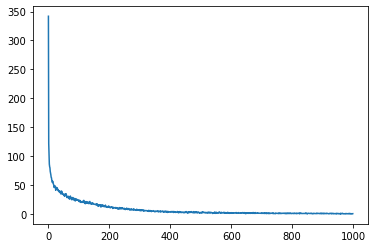

In [284]:
#We can plot the loss during the training process to visualize how the model adapts to the data.
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])
plt.show()

In [285]:
#As we might remember, the only trainable part of the model, was the one used to produce the embeddings.
#This part of the model is extracted and will be put into test usint the testing set.
model = net.get_layer(name="sequential_14")

In [286]:
#Since the data used for training was nornalized first, then we do the same with the testing set.
from sklearn.preprocessing import StandardScaler
x_test = StandardScaler().fit_transform(x_test) # normalizing the features

print(x_test.shape)

#We produce the new embeddings including the contextual information processed, to check its metrics.
result = model.predict(x_test)

print(result.shape)

(900, 2060)
(900, 2288)


In [287]:
#We use eucliudean distance, since is the kind of distance that was used during the training. And calculate every
#Distance between the images in the test set.
result = np.array(result)

distances = []
i = 0
for val1 in result:
    distances.append([])
    for val2 in result:
        distances[i].append(np.sum(np.square(val1-val2)))
    i = i+1

print(distances[0])

[[0.0000000e+00 0.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 4.3342160e-31 ... 1.0000000e+00
  1.2736265e-35 1.0000000e+00]
 ...
 [8.9321512e-26 4.0603411e-17 0.0000000e+00 ... 1.0000000e+00
  7.6171621e-21 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 1.0000000e+00]]
[0.0, 1039.8928, 1273.9568, 1085.5824, 1075.9596, 6.9984913, 1157.0077, 0.0, 1146.6147, 1101.0061, 1014.0001, 1008.90027, 1050.0393, 1082.5659, 1.0, 2.0, 1046.3975, 1003.7072, 1044.1698, 0.99999464, 1117.2886, 1007.9999, 1175.0872, 1006.6907, 1210.7897, 1243.8035, 1011.3418, 1.0, 1020.9072, 0.009017544, 3.9999843, 1007.99994, 1053.1438, 1099.4594, 1224.0007, 1138.4443, 1043.873, 1206.5332, 1004.1285, 1.9959271, 2.9964507, 1015.9999,

In [288]:
#For the test set, a subset of images needs to be selected as query, and the rest is used for the gallery, so no 
#image in the query should exist in the gallery, otherwise the distance would be zero. To ensure that this does 
#not happen, we first change the value to infinity to the distance of every image with itself.
querys = []
verification =  []
    
i = 0
for row in distances:
    row[i]=np.inf
    distances[i] = row
    i = i+1
    
random.seed(20)

#Then we take 20 percent of the test set for querys and the rest for gallery, as it is shown below.
numlst = list(range(len(distances))) 
random.shuffle(numlst)

split = int(len(distances)*0.2)

queryIndexes = numlst[:split]

#In order to calculate the metrics, we take a relevant subset of the ordered data, because at a certain point, the
#rest of the data is not relevant for mean Average Prceision calculation.
mostRelevantIndices = int(len(distances)*0.75)
    
for queryIndex in queryIndexes:
    top_20_idx = np.argsort(distances[queryIndex])[:mostRelevantIndices]
    top_20_values = [distances[queryIndex][i] for i in top_20_idx]
    querys.append(top_20_idx)
    verification.append(top_20_values)

In [289]:
eucDist = [] 
areSame = []
qI = []
rI = []
Id = y_test

#We calculate for each query image against the gallery, its most closest (and therefore more similar) images. Then
#we verify if they are the same, and save the query and gallery indexes, as well as the distances between them.
i = 0
for query in querys:
    for j in range(mostRelevantIndices):
        eucDist.append(verification[i][j])
        areSame.append(int(y_test[query[j]]==y_test[queryIndexes[i]]))
        qI.append(y_test[queryIndexes[i]])
        rI.append(y_test[query[j]])
    i=i+1
    
data3Final = []
data3Final = pd.DataFrame(data3Final)

data3Final['eucDist'] = eucDist
data3Final['areSame'] = areSame
data3Final['qI'] = qI
data3Final['rI'] = rI

print(data3Final)

            eucDist  areSame   qI   rI
0        740.314941        0  343  401
1        741.514893        0  343  401
2        746.135376        0  343  401
3        755.687988        0  343  405
4        756.494019        0  343  405
...             ...      ...  ...  ...
121495  1162.911255        0  484  104
121496  1162.964111        0  484  104
121497  1163.145874        0  484  236
121498  1163.148926        0  484  236
121499  1163.165527        0  484  236

[121500 rows x 4 columns]


In [290]:
from argparse import ArgumentParser, FileType
from importlib import import_module
from itertools import count
import os

import json
import numpy as np
from sklearn.metrics import average_precision_score

average_precision = average_precision_score

# Loop over the query embeddings and compute their APs and the CMC curve.
aps = []
cmc = np.zeros(split, dtype=np.int32)

distances = np.array(data3Final['eucDist'])
pid_matches = np.array(data3Final['areSame'])

print(pid_matches)

[0 0 0 ... 0 0 0]


In [291]:
scores = 1 / (1 + distances)

for i in range(split):
    ap = average_precision(pid_matches[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices], scores[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices])

    if np.isnan(ap):
        print()
        print("WARNING: encountered an AP of NaN!")
        print("This usually means a person only appears once.")
        print("In this case, it's because of {}.".format(i))
        print("I'm excluding this person from eval and carrying on.")
        print()
        continue

    aps.append(ap)
    # Find the first true match and increment the cmc data from there on.
    try:
        k = np.where(pid_matches[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices] == 1)[0][0]
    except:
        k = -1
    cmc[k:] += 1

# Compute the actual cmc and mAP values
cmc = cmc / split
mean_ap = np.mean(aps)

# Save important data
#if args.filename is not None:
#    json.dump({'mAP': mean_ap, 'CMC': list(cmc), 'aps': list(aps)}, args.filename)

# Print out a short summary.
print('mAP: {:.2%} | top-1: {:.2%} top-2: {:.2%} | top-5: {:.2%} | top-10: {:.2%}'.format(mean_ap, cmc[0], cmc[1], cmc[4], cmc[9]))


This usually means a person only appears once.
In this case, it's because of 0.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 15.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 25.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 47.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 51.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 59.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 71.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
I

/home/dell_mserver_01/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


### Original evaluation

In [335]:
import torch
import csv
import numpy as np
import pandas as pd
from sklearn.utils import resample

random.seed(20)

data = pd.read_csv('data3MGN.csv', sep='|', low_memory=False)
data2 = pd.DataFrame(data)

#Data is randomized to partition for training and testing.
data2 = shuffle(data2, random_state = 20)
data2.reset_index(drop=True, inplace=True)

total_instances = len(data2['Id'])

train_test_split = int(total_instances*0.1)

#Removing the contextual data and only preserving the original embedding, as produced by the algorithm.
aditionalData = ["C", "Lat", "Long", "Time", "preInt", "temp", "hum", "press", "WindS", "WindG", "CloudC", "Visb"]

data2_feats = data2.drop(aditionalData, axis = 1)

y = np.array(data2['Id'])
x = data2_feats.loc[:, data2_feats.columns != 'Id']
x = np.array(x.loc[:, x.columns != 'I'])

x_test = x[:train_test_split]
y_test = y[:train_test_split]

print(x_test.shape)

(900, 2048)


In [340]:
from sklearn.metrics.pairwise import euclidean_distances

result = np.array(x_test)
print(result)

distances = euclidean_distances(result, result)
print(distances.shape)

[[0.0000000e+00 0.0000000e+00 3.2944866e-02 ... 1.2496778e-02
  8.9011590e-03 0.0000000e+00]
 [0.0000000e+00 7.2290986e-03 0.0000000e+00 ... 7.4231830e-03
  7.4126170e-03 7.5929540e-03]
 [1.9584304e-02 3.5034932e-02 0.0000000e+00 ... 0.0000000e+00
  8.4962140e-03 2.2696706e-02]
 ...
 [1.1713257e-03 2.1226500e-02 7.2523034e-03 ... 3.4469627e-02
  4.1081984e-02 0.0000000e+00]
 [3.4289554e-02 1.4991448e-02 1.3106362e-02 ... 1.2990595e-02
  2.8399462e-02 0.0000000e+00]
 [1.5578175e-02 1.4936728e-02 5.2867446e-05 ... 0.0000000e+00
  2.6977886e-02 2.5947796e-02]]
(900, 900)


In [341]:
querys = []
verification =  []

i = 0
for row in distances:
    row[i]=np.inf
    distances[i] = row
    i = i+1

random.seed(20)

numlst = list(range(len(distances))) 
random.shuffle(numlst)

split = int(len(distances)*0.2)

queryIndexes = numlst[:split]
     
mostRelevantIndices = int(len(distances)*0.75)
    
for queryIndex in queryIndexes:
    top_20_idx = np.argsort(distances[queryIndex])[:mostRelevantIndices]
    top_20_values = [distances[queryIndex][i] for i in top_20_idx]
    querys.append(top_20_idx)
    verification.append(top_20_values)

In [342]:
eucDist = [] 
areSame = []
qI = []
rI = []
Id = y_test
    
i = 0
for query in querys:
    for j in range(mostRelevantIndices):
        eucDist.append(verification[i][j])
        areSame.append(int(y_test[query[j]]==y_test[queryIndexes[i]]))
        qI.append(y_test[queryIndexes[i]])
        rI.append(y_test[query[j]])
    i=i+1
    
data3Final = []
data3Final = pd.DataFrame(data3Final)

data3Final['eucDist'] = eucDist
data3Final['areSame'] = areSame
data3Final['qI'] = qI
data3Final['rI'] = rI

print(data3Final)

         eucDist  areSame   qI   rI
0       0.789309        1  412  412
1       0.789626        1  412  412
2       0.789781        1  412  412
3       0.794006        1  412  412
4       0.794927        1  412  412
...          ...      ...  ...  ...
121495  1.142417        0   15  109
121496  1.142640        0   15  236
121497  1.142904        0   15  236
121498  1.142963        0   15  236
121499  1.143024        0   15  236

[121500 rows x 4 columns]


In [343]:
from argparse import ArgumentParser, FileType
from importlib import import_module
from itertools import count
import os

import json
import numpy as np
from sklearn.metrics import average_precision_score

average_precision = average_precision_score

# Loop over the query embeddings and compute their APs and the CMC curve.
aps = []
cmc = np.zeros(split, dtype=np.int32)

distances = np.array(data3Final['eucDist'])
pid_matches = np.array(data3Final['areSame'])

print(pid_matches)

[1 1 1 ... 0 0 0]


In [344]:
scores = 1 / (1 + distances)

for i in range(split):
    ap = average_precision(pid_matches[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices], scores[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices])

    if np.isnan(ap):
        print()
        print("WARNING: encountered an AP of NaN!")
        print("This usually means a person only appears once.")
        print("In this case, it's because of {}.".format(i))
        print("I'm excluding this person from eval and carrying on.")
        print()
        continue

    aps.append(ap)
    # Find the first true match and increment the cmc data from there on.
    try:
        k = np.where(pid_matches[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices] == 1)[0][0]
    except:
        k = -1
    cmc[k:] += 1

# Compute the actual cmc and mAP values
cmc = cmc / split
mean_ap = np.mean(aps)

# Save important data
#if args.filename is not None:
#    json.dump({'mAP': mean_ap, 'CMC': list(cmc), 'aps': list(aps)}, args.filename)

# Print out a short summary.
print('mAP: {:.2%} | top-1: {:.2%} top-2: {:.2%} | top-5: {:.2%} | top-10: {:.2%}'.format(mean_ap, cmc[0], cmc[1], cmc[4], cmc[9]))


This usually means a person only appears once.
In this case, it's because of 2.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 7.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 9.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 22.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 23.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 25.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 29.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In 

/home/dell_mserver_01/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


## Approach 3: MLFN Model

In [293]:
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import torch
import csv
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.utils import shuffle

#Loading the embedding features produced for this model along with Contextual Information 
#for each image in the dataset.
data = pd.read_csv('data3MLFN.csv', sep='|', low_memory=False)
data2 = pd.DataFrame(data)

#Modifying range of values of Contextual Information from the data, according to its nature, to a range between 
#0 and 1 to fit the ranges of the embedding features.
data2['C'] = (data2['C'])/3.                      #There are only three possible cameras in the data
data2['Lat'] = (data2['Lat']+90)/180.             #Values go from -90 to 90. So a possible range of 180.
data2['Long'] = (data2['Long']+180)/360.          #Values go from -180 to 180. So a possible range of 360
diff = max(data2['Time'])-min(data2['Time'])      #Obtaining maximum and minimum time in seconds registered in the data.
val = min(data2['Time'])
data2['Time'] = (data2['Time']-val)/diff          #Subtracting the value its difference with zero, and then dividing by the differnce between maximum and minumum times reported
data2['preInt'] = (data2['preInt'])/100.          #Precipitation Intensity exists between 0 and 100
data2['temp'] = (data2['temp']+7.5)/55.           #Normal temperature varies between -7.5 and 47.5
data2['press'] = (data2['press'])-min(data2['press'])
data2['WindS'] = (data2['WindS']-2.8)/2.5         #Wind Speed varies between 2.8 and 5.3 
data2['WindG'] = (data2['WindG']-2.8)/2.5         #Wind Gust varies between 2.8 and 5.3
data2['Visb'] = (data2['Visb'])/296.              #Visibility values go from 0 to 296

#Data is randomized to partition for training and testing.
data2 = shuffle(data2, random_state = 15)
data2.reset_index(drop=True, inplace=True)

total_instances = len(data2['Id'])

train_test_split = int(total_instances*0.1)

#Removing the ID and I columns from the data that will be used to train and test the model.
#Correct Ids are saved as y.
y_train = np.array(data2['Id'])
x_train = data2.loc[:, data2.columns != 'Id']
x_train = np.array(x_train.loc[:, x_train.columns != 'I'])

#Since there are 501 IDS, we take 250 for training and 251 for testing.
x_test = x_train[:train_test_split]
x_train = x_train[train_test_split:]
        
y_test = y_train[:train_test_split]
y_train = y_train[train_test_split:]

# normalizing the features
from sklearn.preprocessing import StandardScaler
x_train = StandardScaler().fit_transform(x_train) 

print(x_train.shape)
print(x_test.shape)

(8100, 1036)
(900, 1036)


In [294]:
#Batches creation, A random image from the training set is selected as well as another image from the same id, and
#an image of different Id.
def create_batch(batch_size):
    anchors = np.zeros((batch_size, 1036))
    positives = np.zeros((batch_size, 1036))
    negatives = np.zeros((batch_size, 1036))
    
    for i in range(0, batch_size):
        #Index of a random image is seleced
        index = random.randint(0, len(x_train) - 1)
        anc = x_train[index]
        #The real ID of the random image is used to guarantee that negative and positive images will be obtained.
        y = y_train[index]
        
        indices_for_pos = np.squeeze(np.where(y_train == y)).reshape(-1,)
        indices_for_neg = np.squeeze(np.where(y_train != y)).reshape(-1,)
        
        pos = x_train[indices_for_pos[random.randint(0, len(indices_for_pos)-1)]]
        neg = x_train[indices_for_neg[random.randint(0, len(indices_for_neg)-1)]]
        
        #Anchor images, positives and negatives are saved and then returned.
        anchors[i] = anc
        positives[i] = pos
        negatives[i] = neg
        
    return [anchors, positives, negatives]

In [296]:
#An embedding dimension is determined for the output of our network. Data will be processed simultaneously through 
#This network in order to learn the weights that let the representation be away from the different images and close
#To the similar images, thus, learning how to make use of contextual information provided.
emb_dim = 2288

embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(2288, activation='relu', input_shape=(1036,)),
    tf.keras.layers.Dense(emb_dim, activation='sigmoid')
])

embedding_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 2288)              2372656   
_________________________________________________________________
dense_31 (Dense)             (None, 2288)              5237232   
Total params: 7,609,888
Trainable params: 7,609,888
Non-trainable params: 0
_________________________________________________________________


In [297]:
#Testing the proper functioning of the model to produce the embeddings. (In this moment, with random weights).
example = x_train[0]

print(np.expand_dims(example, axis=0))

example_emb = embedding_model.predict(np.expand_dims(example, axis=0))[0]
print(example_emb)

[[-1.40771634  0.98134379  1.36046716 ...  0.40844614 -1.
  -1.        ]]
[0.32668242 0.45895597 0.66335833 ... 0.69244325 0.31502956 0.52605414]


In [298]:
#The siamesse neural network structure is defined here. Three layers are used for input to the same embeddings
#model. This results are then fed to a concatenate layer, which produces the very same input but concatenated.

#Since this three embeddings are used to produce the output, and then to calculate the loss, this means that 
#the model is trained with the three data at the same time. Weights are shared, so if a change in the weigts 
#reduces the distance between the anchor and the positive, it should not affect the distance between the anchor 
#and the negative, otherwise, the loss function will not improve.
in_anc = tf.keras.layers.Input(shape=(1036,))
in_pos = tf.keras.layers.Input(shape=(1036,))
in_neg = tf.keras.layers.Input(shape=(1036,))

em_anc = embedding_model(in_anc)
em_pos = embedding_model(in_pos)
em_neg = embedding_model(in_neg)

out = tf.keras.layers.concatenate([em_anc, em_pos, em_neg], axis=1)

net = tf.keras.models.Model(
    [in_anc, in_pos, in_neg],
    out
)
net.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           [(None, 1036)]       0                                            
__________________________________________________________________________________________________
input_41 (InputLayer)           [(None, 1036)]       0                                            
__________________________________________________________________________________________________
input_42 (InputLayer)           [(None, 1036)]       0                                            
__________________________________________________________________________________________________
sequential_15 (Sequential)      (None, 2288)         7609888     input_40[0][0]                   
                                                                 input_41[0][0]            

In [299]:
#Triplet_loss function definition, it receives a parameter alpha to determine the maximum negative distance that 
#can be produced by the embeddings, since the minimum positive distance would be idealy zero.
def triplet_loss(alpha, emb_dim):
    def loss(y_true, y_pred):
        anc, pos, neg = y_pred[:, :emb_dim], y_pred[:, emb_dim:2*emb_dim], y_pred[:, 2*emb_dim:]
        dp = tf.reduce_sum(tf.square(anc-pos), axis=1)
        dn = tf.reduce_sum(tf.square(anc-neg), axis=1)

        return tf.maximum(dp - dn + alpha, 0.)
    return loss

In [300]:
#This function is a generator, which yields batches of triplets with the batch size indicated.
def data_generator(batch_size, emb_dim):
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_dim))
        yield x, y

In [301]:
#The neural network is compiled, a batch size of 500 is defined, and a 1000 epoch training, with a number of steps
#per epoch that when multiplied by the number of batches, is similar to the number of data in the training set.
batch_size = 500
epochs = 1000
steps_per_epoch = int(len(x_train)/batch_size)

net.compile(loss=triplet_loss(alpha=1000, emb_dim=emb_dim), optimizer='adam')

In [302]:
#Finally the training is performed with the previously defined configurations.
history = net.fit(
    data_generator(batch_size, emb_dim),
    epochs=epochs, steps_per_epoch=steps_per_epoch,
    verbose=True
)

  ...
    to  
  ['...']
Train for 16 steps
Epoch 1/1000
16/16 [==============================] - 3s 162ms/step - loss: 352.2291
Epoch 2/1000
16/16 [==============================] - 2s 138ms/step - loss: 145.4072
Epoch 3/1000
16/16 [==============================] - 2s 138ms/step - loss: 129.5080
Epoch 4/1000
16/16 [==============================] - 2s 140ms/step - loss: 113.2374
Epoch 5/1000
16/16 [==============================] - 2s 138ms/step - loss: 106.1044
Epoch 6/1000
16/16 [==============================] - 2s 138ms/step - loss: 99.2571
Epoch 7/1000
16/16 [==============================] - 2s 138ms/step - loss: 94.9397
Epoch 8/1000
16/16 [==============================] - 2s 137ms/step - loss: 90.3674
Epoch 9/1000
16/16 [==============================] - 2s 137ms/step - loss: 86.2905
Epoch 10/1000
16/16 [==============================] - 2s 136ms/step - loss: 81.0220
Epoch 11/1000
16/16 [==============================] - 2s 137ms/step - loss: 77.1052
Epoch 12/1000
16/16 [====

16/16 [==============================] - 2s 139ms/step - loss: 12.3576
Epoch 192/1000
16/16 [==============================] - 2s 139ms/step - loss: 13.1365
Epoch 193/1000
16/16 [==============================] - 2s 140ms/step - loss: 13.6164
Epoch 194/1000
16/16 [==============================] - 2s 144ms/step - loss: 14.4055
Epoch 195/1000
16/16 [==============================] - 2s 140ms/step - loss: 13.3724
Epoch 196/1000
16/16 [==============================] - 2s 139ms/step - loss: 14.0969
Epoch 197/1000
16/16 [==============================] - 2s 140ms/step - loss: 13.3988
Epoch 198/1000
16/16 [==============================] - 2s 140ms/step - loss: 12.8423
Epoch 199/1000
16/16 [==============================] - 2s 139ms/step - loss: 13.3378
Epoch 200/1000
16/16 [==============================] - 2s 140ms/step - loss: 12.8249
Epoch 201/1000
16/16 [==============================] - 2s 140ms/step - loss: 12.3794
Epoch 202/1000
16/16 [==============================] - 2s 139ms/step

16/16 [==============================] - 2s 139ms/step - loss: 5.3001
Epoch 383/1000
16/16 [==============================] - 2s 138ms/step - loss: 4.8814
Epoch 384/1000
16/16 [==============================] - 2s 138ms/step - loss: 5.5351
Epoch 385/1000
16/16 [==============================] - 2s 139ms/step - loss: 4.7408
Epoch 386/1000
16/16 [==============================] - 2s 139ms/step - loss: 6.0762
Epoch 387/1000
16/16 [==============================] - 2s 139ms/step - loss: 5.7734
Epoch 388/1000
16/16 [==============================] - 2s 138ms/step - loss: 4.6880
Epoch 389/1000
16/16 [==============================] - 2s 139ms/step - loss: 5.7644
Epoch 390/1000
16/16 [==============================] - 2s 138ms/step - loss: 4.6359
Epoch 391/1000
16/16 [==============================] - 2s 138ms/step - loss: 5.3862
Epoch 392/1000
16/16 [==============================] - 2s 139ms/step - loss: 4.6909
Epoch 393/1000
16/16 [==============================] - 2s 139ms/step - loss: 4.

16/16 [==============================] - 2s 138ms/step - loss: 3.8154
Epoch 575/1000
16/16 [==============================] - 2s 138ms/step - loss: 2.4719
Epoch 576/1000
16/16 [==============================] - 2s 137ms/step - loss: 3.2415
Epoch 577/1000
16/16 [==============================] - 2s 137ms/step - loss: 2.7745
Epoch 578/1000
16/16 [==============================] - 2s 138ms/step - loss: 2.8690
Epoch 579/1000
16/16 [==============================] - 2s 137ms/step - loss: 2.4214
Epoch 580/1000
16/16 [==============================] - 2s 137ms/step - loss: 2.6448
Epoch 581/1000
16/16 [==============================] - 2s 137ms/step - loss: 2.4861
Epoch 582/1000
16/16 [==============================] - 2s 137ms/step - loss: 3.3310
Epoch 583/1000
16/16 [==============================] - 2s 139ms/step - loss: 2.4118
Epoch 584/1000
16/16 [==============================] - 2s 140ms/step - loss: 2.5079
Epoch 585/1000
16/16 [==============================] - 2s 139ms/step - loss: 2.

16/16 [==============================] - 2s 137ms/step - loss: 2.3858
Epoch 767/1000
16/16 [==============================] - 2s 137ms/step - loss: 1.8997
Epoch 768/1000
16/16 [==============================] - 2s 136ms/step - loss: 1.7914
Epoch 769/1000
16/16 [==============================] - 2s 136ms/step - loss: 1.9997
Epoch 770/1000
16/16 [==============================] - 2s 137ms/step - loss: 2.0421
Epoch 771/1000
16/16 [==============================] - 2s 137ms/step - loss: 1.4939
Epoch 772/1000
16/16 [==============================] - 2s 137ms/step - loss: 2.1518
Epoch 773/1000
16/16 [==============================] - 2s 136ms/step - loss: 1.6560
Epoch 774/1000
16/16 [==============================] - 2s 137ms/step - loss: 1.4827
Epoch 775/1000
16/16 [==============================] - 2s 136ms/step - loss: 1.6739
Epoch 776/1000
16/16 [==============================] - 2s 136ms/step - loss: 1.9273
Epoch 777/1000
16/16 [==============================] - 2s 137ms/step - loss: 2.

16/16 [==============================] - 2s 137ms/step - loss: 1.0012
Epoch 959/1000
16/16 [==============================] - 2s 136ms/step - loss: 1.7724
Epoch 960/1000
16/16 [==============================] - 2s 137ms/step - loss: 1.9812
Epoch 961/1000
16/16 [==============================] - 2s 137ms/step - loss: 2.0167
Epoch 962/1000
16/16 [==============================] - 2s 137ms/step - loss: 2.1222
Epoch 963/1000
16/16 [==============================] - 2s 137ms/step - loss: 1.6666
Epoch 964/1000
16/16 [==============================] - 2s 136ms/step - loss: 2.1628
Epoch 965/1000
16/16 [==============================] - 2s 136ms/step - loss: 1.4353
Epoch 966/1000
16/16 [==============================] - 2s 137ms/step - loss: 1.5948
Epoch 967/1000
16/16 [==============================] - 2s 136ms/step - loss: 1.6225
Epoch 968/1000
16/16 [==============================] - 2s 136ms/step - loss: 1.1881
Epoch 969/1000
16/16 [==============================] - 2s 136ms/step - loss: 0.

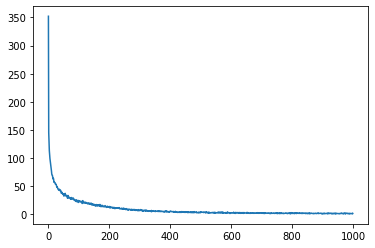

In [303]:
#We can plot the loss during the training process to visualize how the model adapts to the data.
plt.plot(history.history["loss"])
plt.show()

In [304]:
#As we might remember, the only trainable part of the model, was the one used to produce the embeddings.
#This part of the model is extracted and will be put into test usint the testing set.
model = net.get_layer(name="sequential_15")

In [305]:
#Since the data used for training was nornalized first, then we do the same with the testing set.
from sklearn.preprocessing import StandardScaler
x_test = StandardScaler().fit_transform(x_test) # normalizing the features

print(x_test.shape)

#We produce the new embeddings including the contextual information processed, to check its metrics.
result = model.predict(x_test)

print(result.shape)

(900, 1036)
(900, 2288)


In [306]:
#We use eucliudean distance, since is the kind of distance that was used during the training. And calculate every
#Distance between the images in the test set.
from sklearn.metrics.pairwise import euclidean_distances

result = np.array(result)
print(result)

distances = euclidean_distances(result, result)
print(distances.shape)

[[1.9419818e-20 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.1138898e-12 9.3664752e-30]
 [9.9999964e-01 9.9999928e-01 6.0504561e-05 ... 1.0000000e+00
  6.4373528e-12 1.0000000e+00]
 [1.7343443e-21 7.8882577e-17 1.0000000e+00 ... 2.4237292e-30
  1.0000000e+00 7.8425049e-16]
 ...
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [4.1561980e-11 1.0000000e+00 5.5078823e-12 ... 1.0000000e+00
  1.0000000e+00 9.9999893e-01]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]]
(900, 900)


In [307]:
#For the test set, a subset of images needs to be selected as query, and the rest is used for the gallery, so no 
#image in the query should exist in the gallery, otherwise the distance would be zero. To ensure that this does 
#not happen, we first change the value to infinity to the distance of every image with itself.
querys = []
verification =  []
    
i = 0
for row in distances:
    row[i]=np.inf
    distances[i] = row
    i = i+1
    
random.seed(20)

#Then we take 20 percent of the test set for querys and the rest for gallery, as it is shown below.
numlst = list(range(len(distances))) 
random.shuffle(numlst)

split = int(len(distances)*0.2)

queryIndexes = numlst[:split]

#In order to calculate the metrics, we take a relevant subset of the ordered data, because at a certain point, the
#rest of the data is not relevant for mean Average Prceision calculation.     
mostRelevantIndices = int(len(distances)*0.75)
    
for queryIndex in queryIndexes:
    top_20_idx = np.argsort(distances[queryIndex])[:mostRelevantIndices]
    top_20_values = [distances[queryIndex][i] for i in top_20_idx]
    querys.append(top_20_idx)
    verification.append(top_20_values)

In [308]:
eucDist = [] 
areSame = []
qI = []
rI = []
Id = y_test

#We calculate for each query image against the gallery, its most closest (and therefore more similar) images. Then
#we verify if they are the same, and save the query and gallery indexes, as well as the distances between them.
i = 0
for query in querys:
    for j in range(mostRelevantIndices):
        eucDist.append(verification[i][j])
        areSame.append(int(y_test[query[j]]==y_test[queryIndexes[i]]))
        qI.append(y_test[queryIndexes[i]])
        rI.append(y_test[query[j]])
    i=i+1
    
data3Final = []
data3Final = pd.DataFrame(data3Final)

data3Final['eucDist'] = eucDist
data3Final['areSame'] = areSame
data3Final['qI'] = qI
data3Final['rI'] = rI

print(data3Final)

          eucDist  areSame  qI   rI
0        1.586439        1   2    2
1        1.797821        1   2    2
2        1.821401        1   2    2
3        1.829382        1   2    2
4        2.805359        1   2    2
...           ...      ...  ..  ...
121495  34.097660        0  48  334
121496  34.102009        0  48  202
121497  34.107941        0  48  191
121498  34.114704        0  48  202
121499  34.120804        0  48  332

[121500 rows x 4 columns]


In [309]:
from argparse import ArgumentParser, FileType
from importlib import import_module
from itertools import count
import os

import json
import numpy as np
from sklearn.metrics import average_precision_score

average_precision = average_precision_score

# Loop over the query embeddings and compute their APs and the CMC curve.
aps = []
cmc = np.zeros(split, dtype=np.int32)

distances = np.array(data3Final['eucDist'])
pid_matches = np.array(data3Final['areSame'])

print(pid_matches)

[1 1 1 ... 0 0 0]


In [310]:
scores = 1 / (1 + distances)

for i in range(split):
    ap = average_precision(pid_matches[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices], scores[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices])

    if np.isnan(ap):
        print()
        print("WARNING: encountered an AP of NaN!")
        print("This usually means a person only appears once.")
        print("In this case, it's because of {}.".format(i))
        print("I'm excluding this person from eval and carrying on.")
        print()
        continue

    aps.append(ap)
    # Find the first true match and increment the cmc data from there on.
    try:
        k = np.where(pid_matches[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices] == 1)[0][0]
    except:
        k = -1
    cmc[k:] += 1

# Compute the actual cmc and mAP values
cmc = cmc / split
mean_ap = np.mean(aps)

# Save important data
#if args.filename is not None:
#    json.dump({'mAP': mean_ap, 'CMC': list(cmc), 'aps': list(aps)}, args.filename)

# Print out a short summary.
print('mAP: {:.2%} | top-1: {:.2%} top-2: {:.2%} | top-5: {:.2%} | top-10: {:.2%}'.format(mean_ap, cmc[0], cmc[1], cmc[4], cmc[9]))


This usually means a person only appears once.
In this case, it's because of 4.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 5.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 27.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 28.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 45.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 68.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 72.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In

/home/dell_mserver_01/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


### Original evaluation.

In [351]:
import torch
import csv
import numpy as np
import pandas as pd
from sklearn.utils import resample

random.seed(20)

data = pd.read_csv('data3MLFN.csv', sep='|', low_memory=False)
data2 = pd.DataFrame(data)

#Data is randomized to partition for training and testing.
data2 = shuffle(data2, random_state = 15)
data2.reset_index(drop=True, inplace=True)

total_instances = len(data2['Id'])

train_test_split = int(total_instances*0.1)

#Removing the contextual data and only preserving the original embedding, as produced by the algorithm.
aditionalData = ["C", "Lat", "Long", "Time", "preInt", "temp", "hum", "press", "WindS", "WindG", "CloudC", "Visb"]

data2_feats = data2.drop(aditionalData, axis = 1)

y = np.array(data2['Id'])
x = data2_feats.loc[:, data2_feats.columns != 'Id']
x = np.array(x.loc[:, x.columns != 'I'])

x_test = x[:train_test_split]
y_test = y[:train_test_split]

print(x_test.shape)

(900, 1024)


In [352]:
from sklearn.metrics.pairwise import euclidean_distances

result = np.array(x_test)
print(result)

distances = euclidean_distances(result, result)
print(distances.shape)

[[0.19079278 0.41835076 0.         ... 0.85736042 0.44060814 0.74042809]
 [0.55913693 0.         0.46748087 ... 0.11755289 1.3501972  0.72903746]
 [0.         0.84343219 0.         ... 1.45627618 0.07782221 0.36819813]
 ...
 [0.         0.73704767 0.2313377  ... 0.50969577 0.03541083 0.09176115]
 [0.06145915 0.58987004 0.195676   ... 0.83745492 0.08668592 0.        ]
 [0.46776474 0.26033071 0.         ... 0.         0.10226339 0.        ]]
(900, 900)


In [353]:
querys = []
verification =  []

i = 0
for row in distances:
    row[i]=np.inf
    distances[i] = row
    i = i+1

random.seed(20)

numlst = list(range(len(distances))) 
random.shuffle(numlst)

split = int(len(distances)*0.2)

queryIndexes = numlst[:split]
     
mostRelevantIndices = int(len(distances)*0.75)
    
for queryIndex in queryIndexes:
    top_20_idx = np.argsort(distances[queryIndex])[:mostRelevantIndices]
    top_20_values = [distances[queryIndex][i] for i in top_20_idx]
    querys.append(top_20_idx)
    verification.append(top_20_values)

In [354]:
eucDist = [] 
areSame = []
qI = []
rI = []
Id = y_test
    
i = 0
for query in querys:
    for j in range(mostRelevantIndices):
        eucDist.append(verification[i][j])
        areSame.append(int(y_test[query[j]]==y_test[queryIndexes[i]]))
        qI.append(y_test[queryIndexes[i]])
        rI.append(y_test[query[j]])
    i=i+1
    
data3Final = []
data3Final = pd.DataFrame(data3Final)

data3Final['eucDist'] = eucDist
data3Final['areSame'] = areSame
data3Final['qI'] = qI
data3Final['rI'] = rI

print(data3Final)

          eucDist  areSame   qI   rI
0        2.173181        1  157  157
1        2.248104        1  157  157
2        2.560495        1  157  157
3        2.914259        1  157  157
4        3.125547        1  157  157
...           ...      ...  ...  ...
121495  14.633491        0  377  213
121496  14.641548        0  377  236
121497  14.643129        0  377  236
121498  14.643323        0  377   48
121499  14.644911        0  377  238

[121500 rows x 4 columns]


In [355]:
from argparse import ArgumentParser, FileType
from importlib import import_module
from itertools import count
import os

import json
import numpy as np
from sklearn.metrics import average_precision_score


average_precision = average_precision_score

# Loop over the query embeddings and compute their APs and the CMC curve.
aps = []
cmc = np.zeros(split, dtype=np.int32)

distances = np.array(data3Final['eucDist'])
pid_matches = np.array(data3Final['areSame'])

print(pid_matches)

[1 1 1 ... 0 0 0]


In [356]:
scores = 1 / (1 + distances)

for i in range(split):
    ap = average_precision(pid_matches[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices], scores[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices])

    if np.isnan(ap):
        print()
        print("WARNING: encountered an AP of NaN!")
        print("This usually means a person only appears once.")
        print("In this case, it's because of {}.".format(i))
        print("I'm excluding this person from eval and carrying on.")
        print()
        continue

    aps.append(ap)
    # Find the first true match and increment the cmc data from there on.
    try:
        k = np.where(pid_matches[mostRelevantIndices*i:(mostRelevantIndices*i)+mostRelevantIndices] == 1)[0][0]
    except:
        k = -1
    cmc[k:] += 1

# Compute the actual cmc and mAP values
cmc = cmc / split
mean_ap = np.mean(aps)

# Save important data
#if args.filename is not None:
#    json.dump({'mAP': mean_ap, 'CMC': list(cmc), 'aps': list(aps)}, args.filename)

# Print out a short summary.
print('mAP: {:.2%} | top-1: {:.2%} top-2: {:.2%} | top-5: {:.2%} | top-10: {:.2%}'.format(mean_ap, cmc[0], cmc[1], cmc[4], cmc[9]))


This usually means a person only appears once.
In this case, it's because of 18.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 24.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 26.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 32.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 52.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 74.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.
In this case, it's because of 85.
I'm excluding this person from eval and carrying on.


This usually means a person only appears once.


/home/dell_mserver_01/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


# Memory cleaning

In [34]:
import torch, gc
gc.collect()

torch.cuda.empty_cache()

74